In [1]:
# Imports

# Gymnasium
# -----------------------
import gymnasium as gym
from gymnasium import spaces
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import numpy as np

# -----------------------
# Stable Baselines 3
# -----------------------
import optuna
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from qlearning import tabular_q_learning


# -----------------------
# Importing the water environment
# -----------------------
from env_nosell import create_env, SimplifiedWaterSupplyEnv

In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor


def make_tabular_env(time_buckets=10, water_buckets=5, max_cycles=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing both observations and actions.
    """
    env = create_env(max_cycles=max_cycles,
                     time_buckets=time_buckets,
                     water_buckets=water_buckets,
                     discrete_actions=True,
                     discrete_observations=True)
    return Monitor(env, filename='tabular q')

def make_dqn_env(time_buckets=10, water_buckets=5, max_cycles=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing both observations and actions.
    """
    env = create_env(max_cycles=max_cycles,
                     time_buckets=time_buckets,
                     water_buckets=water_buckets,
                     discrete_actions=True,
                     discrete_observations=False,
                     normalize_actions=False,
                     normalize_observations=True)
    
    return Monitor(env, filename='dqn')



def make_a2c_env(max_cycles=5):
    env = create_env(max_cycles=max_cycles,
                    discrete_actions=False,
                    discrete_observations=False,
                    normalize_actions=True,
                    normalize_observations=True)
    return Monitor(env, filename='a2c')


In [3]:
env = make_tabular_env(time_buckets=10, water_buckets=10)
Q, rewards = tabular_q_learning(env, total_episodes=100)

Episode 100: Total Reward = -30523.197500000002


In [4]:
from env_nosell import HOURS_IN_A_WEEK

# 1. Tabular q-learning objective
def tabular_q_learning_objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.9, 1)
    epsilon = trial.suggest_float("epsilon", 0.01, 1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.01, 1)
    time_buckets = trial.suggest_categorical('time_buckets', [5, 10, 20])
    water_buckets = trial.suggest_categorical('water_buckets', [5, 10, 20])
    max_cycles = trial.suggest_categorical('max_cycles', [1, 3, 5])

    total_timesteps = 50000  # Use a smaller budget for tuning

    env = make_tabular_env(time_buckets, water_buckets)
    # Run Q-learning for num_episodes episodes
    Q, total_rewards = tabular_q_learning(env,
                                          total_episodes=total_timesteps // (HOURS_IN_A_WEEK * max_cycles),
                                          learning_rate=learning_rate,
                                          gamma=gamma,
                                          epsilon=epsilon,
                                          epsilon_decay=epsilon_decay)
    
    # Return the average reward (since we want to maximize reward)
    return np.mean(total_rewards)

# 2. DQN objective using Stable-Baselines3.
def objective_dqn(trial):
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    buffer_size = trial.suggest_categorical('buffer_size', [50000, 100000, 200000])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.5)
    exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.01, 0.1)
    target_update_interval = trial.suggest_categorical('target_update_interval', [100, 500, 1000])
    time_buckets = trial.suggest_categorical('time_buckets', [5, 10, 20])
    water_buckets = trial.suggest_categorical('water_buckets', [5, 10, 20])
    max_cycles = trial.suggest_categorical('max_cycles', [1, 3, 5])
    
    env = make_dqn_env(time_buckets,
                       water_buckets,
                       max_cycles)
    model = DQN("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma,
                buffer_size=buffer_size, batch_size=batch_size,
                exploration_fraction=exploration_fraction, exploration_final_eps=exploration_final_eps,
                target_update_interval=target_update_interval, verbose=0, device='cpu')
    # Train for a limited number of timesteps.
    model.learn(total_timesteps=50000, progress_bar=True)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

# 3. A2C objective using Stable-Baselines3.
def objective_a2c(trial):
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    n_steps = trial.suggest_categorical('n_steps', [5, 10, 20, 50])
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.5, 1.0)
    max_cycles = trial.suggest_categorical('max_cycles', [1, 3, 5])
    
    env=make_a2c_env(max_cycles)
    model = A2C("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma, n_steps=n_steps,
                ent_coef=ent_coef, vf_coef=vf_coef, max_grad_norm=max_grad_norm, verbose=0, device='cpu')
    model.learn(total_timesteps=50000, progress_bar=True)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

study_tabular = optuna.create_study(direction="maximize")
study_tabular.optimize(tabular_q_learning_objective, n_trials=3)
print("Best hyperparameters for Tabular Q-learning:", study_tabular.best_trial.params)

# Tune DQN.
study_dqn = optuna.create_study(direction="maximize")
study_dqn.optimize(objective_dqn, n_trials=3)
print("Best hyperparameters for DQN:", study_dqn.best_trial.params)

# Tune A2C.
study_a2c = optuna.create_study(direction="maximize")
study_a2c.optimize(objective_a2c, n_trials=3)
print("Best hyperparameters for A2C:", study_a2c.best_trial.params)


[I 2025-02-27 14:20:49,984] A new study created in memory with name: no-name-fcd1b0c6-3f29-47a0-9493-80d4f40f32ce
[I 2025-02-27 14:20:50,688] Trial 0 finished with value: -24448.481567796607 and parameters: {'lr': 3.110091336634101e-05, 'gamma': 0.9248211881244226, 'epsilon': 0.4215744951017936, 'epsilon_decay': 0.9555681067228154, 'time_buckets': 5, 'water_buckets': 20, 'max_cycles': 5}. Best is trial 0 with value: -24448.481567796607.
[I 2025-02-27 14:20:51,855] Trial 1 finished with value: -12531.851691919193 and parameters: {'lr': 0.0002777246984114998, 'gamma': 0.9667364962690591, 'epsilon': 0.7167870921539367, 'epsilon_decay': 0.1373513510370052, 'time_buckets': 5, 'water_buckets': 10, 'max_cycles': 3}. Best is trial 1 with value: -12531.851691919193.
[I 2025-02-27 14:20:53,283] Trial 2 finished with value: -229204.67724747493 and parameters: {'lr': 3.6636138491267526e-05, 'gamma': 0.9957031684027895, 'epsilon': 0.38461880560586037, 'epsilon_decay': 0.8371944148484016, 'time_buck

Best hyperparameters for Tabular Q-learning: {'lr': 0.0002777246984114998, 'gamma': 0.9667364962690591, 'epsilon': 0.7167870921539367, 'epsilon_decay': 0.1373513510370052, 'time_buckets': 5, 'water_buckets': 10, 'max_cycles': 3}


Output()

[I 2025-02-27 14:21:35,868] Trial 0 finished with value: -2074654.2520566 and parameters: {'lr': 3.3307959158168144e-05, 'gamma': 0.9414553602431617, 'buffer_size': 200000, 'batch_size': 128, 'exploration_fraction': 0.4633446733100721, 'exploration_final_eps': 0.08369914984371263, 'target_update_interval': 1000, 'time_buckets': 20, 'water_buckets': 5, 'max_cycles': 3}. Best is trial 0 with value: -2074654.2520566.


Output()

[I 2025-02-27 14:22:21,709] Trial 1 finished with value: -2064808.1008138 and parameters: {'lr': 2.403604637023263e-05, 'gamma': 0.9293574383604317, 'buffer_size': 50000, 'batch_size': 32, 'exploration_fraction': 0.12463348629314508, 'exploration_final_eps': 0.08340380310661487, 'target_update_interval': 500, 'time_buckets': 20, 'water_buckets': 20, 'max_cycles': 3}. Best is trial 1 with value: -2064808.1008138.


Output()

[I 2025-02-27 14:23:32,562] Trial 2 finished with value: -2816.7 and parameters: {'lr': 0.0006800985018687493, 'gamma': 0.9334793341072307, 'buffer_size': 100000, 'batch_size': 64, 'exploration_fraction': 0.17519319147335743, 'exploration_final_eps': 0.010580555679694272, 'target_update_interval': 1000, 'time_buckets': 5, 'water_buckets': 20, 'max_cycles': 3}. Best is trial 2 with value: -2816.7.
[I 2025-02-27 14:23:32,563] A new study created in memory with name: no-name-f8faeee7-0007-454a-98ab-0e6d361d623f


Output()

C:\Users\AcerC\AppData\Local\Temp\ipykernel_12308\1078269356.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)


Best hyperparameters for DQN: {'lr': 0.0006800985018687493, 'gamma': 0.9334793341072307, 'buffer_size': 100000, 'batch_size': 64, 'exploration_fraction': 0.17519319147335743, 'exploration_final_eps': 0.010580555679694272, 'target_update_interval': 1000, 'time_buckets': 5, 'water_buckets': 20, 'max_cycles': 3}


[I 2025-02-27 14:24:08,018] Trial 0 finished with value: -6251171.7792812 and parameters: {'lr': 8.367131490283087e-05, 'gamma': 0.9743968425834182, 'n_steps': 20, 'ent_coef': 0.0030710167855003243, 'vf_coef': 0.7114732784462615, 'max_grad_norm': 0.5373130035179039, 'max_cycles': 1}. Best is trial 0 with value: -6251171.7792812.


Output()

[I 2025-02-27 14:24:38,038] Trial 1 finished with value: -19174000.7299202 and parameters: {'lr': 0.00013753529309487418, 'gamma': 0.9816586442167856, 'n_steps': 50, 'ent_coef': 5.316035139200117e-05, 'vf_coef': 0.920372750165694, 'max_grad_norm': 0.9473522659657454, 'max_cycles': 3}. Best is trial 0 with value: -6251171.7792812.


Output()

[I 2025-02-27 14:25:09,903] Trial 2 finished with value: -32366265.4864286 and parameters: {'lr': 6.549885522737965e-05, 'gamma': 0.9338719931231774, 'n_steps': 50, 'ent_coef': 4.490158181848519e-07, 'vf_coef': 0.9289675113443272, 'max_grad_norm': 0.6035720878233726, 'max_cycles': 5}. Best is trial 0 with value: -6251171.7792812.


Best hyperparameters for A2C: {'lr': 8.367131490283087e-05, 'gamma': 0.9743968425834182, 'n_steps': 20, 'ent_coef': 0.0030710167855003243, 'vf_coef': 0.7114732784462615, 'max_grad_norm': 0.5373130035179039, 'max_cycles': 1}


In [6]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Import RL algorithms from Stable-Baselines3
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# ========================================================
# STEP 3: BASELINE PERFORMANCE COMPARISON SETUP
# ========================================================
# We assume the water supply environment ("YourWaterSupplyEnv-v0")
# is registered with Gymnasium and uses discrete observation/action spaces.
# We also assume that the tabular Q-learning implementation (q_learning function)
# and the optimal hyperparameters for each algorithm have already been obtained.

# --- (1) Define the experiment runners for each agent type ---
# Each function runs the corresponding algorithm for a fixed training duration,
# evaluates performance on evaluation episodes, and returns the evaluation score.

# (a) Tabular Q-Learning Experiment Runner
def run_tabular_q_learning(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the tabular Q-learning experiment with given seed and hyperparameters.
    
    optimal_params: dict with keys 'alpha', 'gamma', 'epsilon', and 'num_episodes'
    Returns: Average reward over evaluation episodes.
    """
    np.random.seed(seed)
    env = make_tabular_env(time_buckets=optimal_params['time_buckets'],
                           water_buckets=optimal_params['water_buckets'],
                           max_cycles=optimal_params['max_cycles'])
    # Set the environment seed (if supported by your environment)
    env.reset(seed=seed)
    
    # Run our previously defined Q-learning algorithm.
    Q, rewards_all = tabular_q_learning(env,
                                total_episodes=total_timesteps // (HOURS_IN_A_WEEK * optimal_params['max_cycles']),
                                learning_rate=optimal_params['lr'],
                                gamma=optimal_params['gamma'],
                                epsilon=optimal_params['epsilon'],
                                epsilon_decay=optimal_params['epsilon_decay'])
    
    # Evaluate the learned Q-table:
    # Here we use a simple evaluation function: run a few episodes with a greedy policy.
    eval_rewards = []
    env = make_tabular_env(time_buckets=optimal_params['time_buckets'],
                           water_buckets=optimal_params['water_buckets'],
                           max_cycles=optimal_params['max_cycles'])
    for _ in range(n_eval_episodes):
        state, info = env.reset()
        done = False
        truncated = False
        total_reward = 0
        while not done and not truncated:
            # Greedy action selection based on Q-table.
            action = int(np.argmax(Q[state]))
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
        eval_rewards.append(total_reward)
    training_times = env.get_episode_times()
    return eval_rewards, [rewards_all], training_times, Q, env

# (b) DQN Experiment Runner using Stable-Baselines3
def run_dqn(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the DQN experiment with the given seed and hyperparameters.
    
    optimal_params: dict with keys such as 'learning_rate', 'gamma', etc.
    Returns: Mean reward over evaluation episodes.
    """
    env = make_dqn_env(time_buckets=optimal_params['time_buckets'],
                       water_buckets=optimal_params['water_buckets'],
                       max_cycles=optimal_params['max_cycles'])
    
    env.reset(seed=seed)
    model = DQN("MlpPolicy", env,
                learning_rate=optimal_params['lr'],
                gamma=optimal_params['gamma'],
                buffer_size=optimal_params['buffer_size'],
                batch_size=optimal_params['batch_size'],
                exploration_fraction=optimal_params['exploration_fraction'],
                exploration_final_eps=optimal_params['exploration_final_eps'],
                target_update_interval=optimal_params['target_update_interval'],
                seed=seed,
                verbose=0,
                device='cpu')
    # Train model for a fixed number of timesteps.
    model.learn(total_timesteps=total_timesteps, progress_bar=True)
    eval_rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    training_rewards = env.get_episode_rewards()
    training_times = env.get_episode_times()
    return eval_rewards, [training_rewards], training_times, model, env

# (c) A2C Experiment Runner using Stable-Baselines3
def run_a2c(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the A2C experiment with the given seed and hyperparameters.
    
    optimal_params: dict with keys such as 'lr', 'gamma', 'n_steps', etc.
    Returns: Mean reward over evaluation episodes.
    """
    env = make_a2c_env()
    env.reset(seed=seed)
    model = A2C("MlpPolicy", env,
                learning_rate=optimal_params['lr'],
                gamma=optimal_params['gamma'],
                n_steps=optimal_params['n_steps'],
                ent_coef=optimal_params['ent_coef'],
                vf_coef=optimal_params['vf_coef'],
                max_grad_norm=optimal_params['max_grad_norm'],
                seed=seed,
                verbose=0,
                device='cpu')
    model.learn(total_timesteps=total_timesteps, progress_bar=True)
    eval_rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    training_rewards = env.get_episode_rewards()
    training_times = env.get_episode_times()
    return eval_rewards, [training_rewards], training_times, model, env

# ========================================================
# (2) Run Experiments Across Multiple Seeds for Each Agent
# ========================================================
# Define a list of seeds for reproducibility.
seeds = range(4)

# Assume these optimal hyperparameters have been determined from Step 2.
optimal_params_tabular = study_tabular.best_trial.params

optimal_params_dqn = study_dqn.best_trial.params

optimal_params_a2c = study_a2c.best_trial.params

# Containers for results: a dictionary mapping algorithm name to list of evaluation rewards.
results = {
    "Tabular_Q": [],
    "DQN": [],
    "A2C": []
}

learning_curves = {"Tabular_Q": [],
                   "DQN": [],
                   "A2C": []}
training_times = {"Tabular_Q": [],
                  "DQN": [],
                  "A2C": []}



# Run experiments for each seed.
for seed in seeds:
    print(f"Running experiment with seed: {seed}")
    
    # Run Tabular Q-learning.
    reward_tabular, tabular_learning_curve, tabular_training_times, Q, tabular_env = run_tabular_q_learning(seed,
                                                                                                            optimal_params_tabular,
                                                                                                            total_timesteps=50000,
                                                                                                            n_eval_episodes=1000)
    results["Tabular_Q"].append(reward_tabular)
    learning_curves['Tabular_Q'].append(np.array(tabular_learning_curve))
    training_times['Tabular_Q'].append(tabular_training_times)
    print(f"Tabular Q-learning (seed {seed}): {reward_tabular}")
    
    # Run DQN.
    reward_dqn, dqn_learning_curve, dqn_training_times, dqn_model, dqn_env = run_dqn(seed,
                                                                                     optimal_params_dqn,
                                                                                     total_timesteps=50000,
                                                                                     n_eval_episodes=1000)
    results["DQN"].append(reward_dqn)
    learning_curves['DQN'].append(np.array(dqn_learning_curve))
    training_times['DQN'].append(dqn_training_times)
    print(f"DQN (seed {seed}): {reward_dqn}")
    
    # Run A2C.
    reward_a2c, a2c_learning_curve, a2c_training_times, a2c_model, a2c_env = run_a2c(seed,
                                                                                     optimal_params_a2c,
                                                                                     total_timesteps=50000,
                                                                                     n_eval_episodes=1000)
    results["A2C"].append(reward_a2c)
    learning_curves['A2C'].append(np.array(a2c_learning_curve))
    training_times['A2C'].append(a2c_training_times)
    print(f"A2C (seed {seed}): {reward_a2c}")


learning_curves = {a: np.array(s) for a, s in learning_curves.items()}
results = {a: np.array(s) for a, s in results.items()}
training_times = {a: np.array(s) for a, s in training_times.items()}

a2c_model.save("a2c_model")
dqn_model.save("dqn_model")



Running experiment with seed: 0


Output()

Tabular Q-learning (seed 0): [-5017.7625, -6341.6625, -5174.362499999999, -5588.3625, -5330.9625, -5487.562499999999, -5330.9625, -5487.562499999999, -5487.562499999999, -5330.9625, -5330.9625, -5330.962499999999, -6185.0625, -5487.562499999999, -5487.562499999999, -6341.662499999998, -5330.962499999999, -6185.062499999998, -5330.9625, -5174.362499999999, -6341.662499999998, -6442.462499999999, -5330.962499999999, -5330.9625, -6185.062499999999, -6341.6625, -5330.9625, -5487.562499999999, -5174.3625, -5174.362499999999, -5588.3625, -6341.6625, -5330.9625, -5330.962499999999, -6341.662499999998, -5431.762499999999, -5487.562499999999, -5174.362499999999, -5487.562499999999, -5330.9625, -5174.3625, -6341.6625, -5330.962499999999, -5487.562499999999, -5330.9625, -5330.9625, -5487.562499999999, -5017.7625, -6341.662499999998, -6341.662499999999, -5487.562499999999, -5431.762500000001, -5487.562499999999, -5330.962499999999, -5330.9625, -5330.962499999999, -5174.3625, -5174.362499999999, -6

Output()

DQN (seed 0): [-2104.0125, -2104.0125, -1472.8875, -2104.0125, -2104.0125, -2104.0125, -1472.8875, -2104.0125, -1893.6375, -1893.6375, -1893.6375, -1472.8875, -1893.6375, -2104.0125, -2104.0125, -1893.6375, -1472.8875, -2104.0125, -2104.0125, -2104.0125, -2104.0125, -2104.0125, -1893.6375, -2104.0125, -1472.8875, -1472.8875, -1472.8875, -2104.0125, -1472.8875, -1893.6375, -1472.8875, -1472.8875, -1893.6375, -1472.8875, -1893.6375, -1893.6375, -2104.0125, -2104.0125, -2104.0125, -1893.6375, -1472.8875, -2104.0125, -1893.6375, -1472.8875, -1472.8875, -1472.8875, -1893.6375, -2104.0125, -1893.6375, -1893.6375, -1893.6375, -2104.0125, -2104.0125, -1893.6375, -2104.0125, -2104.0125, -2104.0125, -2104.0125, -2104.0125, -1893.6375, -1893.6375, -1893.6375, -2104.0125, -2104.0125, -1472.8875, -2104.0125, -2104.0125, -1472.8875, -1472.8875, -2104.0125, -2104.0125, -1893.6375, -1472.8875, -2104.0125, -2104.0125, -2104.0125, -1893.6375, -1893.6375, -1472.8875, -1472.8875, -2104.0125, -2104.0125, -

A2C (seed 0): [-32651906.060163, -32523641.310457, -32345150.862899, -32337681.941534, -32429335.441853, -32659149.882264, -32252113.871532, -32225935.456666, -32166652.435022, -32342244.952349, -32117635.35535, -32484737.774676, -32758493.44505, -32703518.563018, -32531643.546957, -32623768.221275, -32330572.708106, -32551508.318051, -32391176.37592, -32246855.625468, -32500823.317282, -32506540.705037, -32266238.601139, -32823623.99366, -32469172.615672, -32137720.578282, -32294362.164203, -32669563.503977, -32758457.286951, -32513527.538162, -32134911.033373, -32521401.477743, -32630119.741937, -32529582.24284, -32655662.782191, -32419857.173645, -32347243.540398, -31882222.996467, -32455220.181375, -32178393.844235, -32660694.444515, -32008056.391805, -32251447.768938, -32100192.1413, -32052546.911251, -32697626.975237, -32506265.595968, -32645596.003623, -32169700.483865, -32300190.162586, -32048820.679207, -32884149.208891, -32425871.418858, -32301449.387634, -32549225.29017, -32

Output()

Tabular Q-learning (seed 1): [-5921.447499999998, -4288.7625, -5112.3475, -4288.7625, -4288.7625, -5948.447499999999, -4288.7625, -5711.7475, -4288.7625, -4288.7625, -5322.0475, -5322.0475, -5711.747499999999, -4288.7625, -4288.7625, -5948.447499999999, -4288.7625, -5112.3475, -6535.3324999999995, -5322.0475, -4288.7625, -5921.4475, -4288.7625, -4288.7625, -5322.0475, -5322.0475, -5711.747499999999, -4288.7625, -5322.0475, -4288.7625, -5322.0475, -4288.7625, -4445.447499999999, -5921.4475, -4915.1625, -5711.747499999999, -5948.447499999999, -7554.132499999999, -5921.447499999999, -6745.032499999999, -4288.7625, -5322.0475, -5322.0475, -5322.0475, -5112.3475, -6547.847499999999, -4915.1625, -4915.1625, -4288.7625, -5738.7474999999995, -4288.7625, -5948.447499999999, -6954.7325, -4288.7625, -4288.7625, -4288.7625, -5112.3475, -5322.0475, -4076.3625, -5921.447499999998, -4288.7625, -5948.447499999999, -4915.1625, -5711.7475, -4288.7625, -5112.3475, -5921.4475, -5322.0475, -5738.7474999999

Output()

DQN (seed 1): [-1383.225, -1334.2875, -1383.225, -1334.2875, -1383.225, -1334.2875, -1503.6, -1334.2875, -1334.2875, -1334.2875, -1383.225, -1334.2875, -1334.2875, -1383.225, -1383.225, -1334.2875, -1334.2875, -1383.225, -1383.225, -1383.225, -1334.2875, -1334.2875, -1503.6, -1383.225, -1285.35, -1285.35, -1432.1625, -1383.225, -1383.225, -1334.2875, -1383.225, -1383.225, -1383.225, -1334.2875, -1334.2875, -1334.2875, -1383.225, -1383.225, -1285.35, -1383.225, -1285.35, -1383.225, -1383.225, -1334.2875, -1334.2875, -1285.35, -1383.225, -1383.225, -1432.1625, -1285.35, -1334.2875, -1334.2875, -1383.225, -1334.2875, -1334.2875, -1334.2875, -1334.2875, -1383.225, -1383.225, -1383.225, -1503.6, -1285.35, -1334.2875, -1334.2875, -1334.2875, -1383.225, -1454.6625, -1334.2875, -1383.225, -1334.2875, -1334.2875, -1334.2875, -1383.225, -1334.2875, -1383.225, -1383.225, -1334.2875, -1383.225, -1285.35, -1334.2875, -1383.225, -1285.35, -1334.2875, -1454.6625, -1383.225, -1383.225, -1503.6, -1383.

A2C (seed 1): [-32409472.716726, -32398633.270503, -32148044.85904, -32475151.190289, -32634230.814524, -32152239.114555, -32693006.053584, -32409529.853022, -32395625.89007, -32499844.160739, -32966236.424942, -32307153.796635, -32898365.590644, -32186384.29332, -32042711.658543, -31799997.825194, -32229743.592117, -32671144.148428, -32351371.898233, -31873775.556683, -32577610.178774, -32245180.446624, -32689994.591264, -32437938.754956, -32375423.041805, -32399646.263835, -32478176.383034, -32531559.875284, -32690091.545427, -32602533.124609, -31910666.974131, -32013120.292287, -32133045.350185, -32443169.112001, -31992258.071885, -32057403.681437, -32354805.002817, -32258790.217515, -32150339.795318, -32100472.60507, -32332280.404223, -32112860.277701, -32373511.830526, -32377329.583928, -32466926.877286, -32055634.194018, -32507984.971682, -31974807.499725, -32436391.077099, -32568765.641266, -32337986.814021, -32256153.441163, -32234742.813183, -32320158.767136, -32144594.25475, 

Output()

Tabular Q-learning (seed 2): [-4100.662499999999, -4100.6625, -3413.9625, -4100.6625, -4100.6625, -4100.662499999999, -4100.662499999999, -3413.9625, -4100.6625, -3170.0625000000005, -3413.9625, -3413.9625, -4100.6625, -3413.9625, -4100.6625, -4100.6625, -3413.9625, -4690.247499999999, -3413.9625, -4100.662499999999, -4100.662499999999, -3413.9625, -4100.6625, -4100.6625, -4690.2475, -4787.3625, -4100.6625, -3413.9625, -4100.662499999999, -5376.947499999998, -4100.6625, -4100.662499999999, -4690.2475, -4100.6625, -3413.9625, -3413.9625, -4612.847499999999, -4690.2475, -3170.0625000000005, -5376.947499999998, -4100.6625, -4100.6625, -3413.9625, -4100.662499999999, -4100.6625, -3413.9625, -4100.6625, -3413.9625, -3413.9625, -3413.9625, -4100.6625, -5299.5475, -3413.9625, -5966.532499999999, -3413.9625, -4100.6625, -3413.9625, -4100.6625, -4100.6625, -3413.9625, -3413.9625, -3413.9625, -4100.6625, -5299.547499999999, -4100.6625, -5966.5325, -3413.9625, -4787.3625, -5376.9475, -3413.9625, 

KeyboardInterrupt: 

In [ ]:
results

{'Tabular_Q': array([[-25808.925 , -25808.925 , -25808.925 , -26551.65  , -25808.925 ],
        [-23695.05  , -24249.675 , -24198.6   , -24224.1375, -23669.5125]]),
 'DQN': array([[-0.0875, -0.0875, -0.0875, -0.0875, -0.0875],
        [-0.0875, -0.0875, -0.0875, -0.0875, -0.0875]]),
 'A2C': array([[-32651906.060163, -32523641.310457, -32345150.862899,
         -32337681.941534, -32429335.441853],
        [-32409472.716726, -32398633.270503, -32148044.85904 ,
         -32475151.190289, -32634230.814524]])}

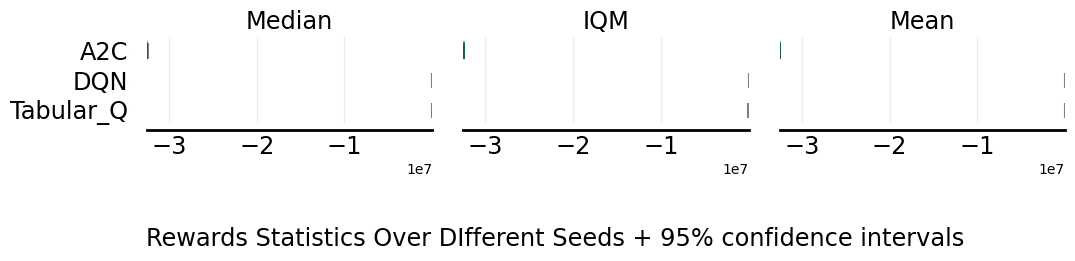

In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd


algorithms = list(learning_curves.keys())

aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  results, aggregate_func, reps=1000)


fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean'],
  algorithms=list(results.keys()),
  xlabel='Rewards Statistics Over DIfferent Seeds + 95% confidence intervals',
  xlabel_y_coordinate=-1
  )

In [ ]:
training_times

{'Tabular_Q': array([[0.01229882, 0.02328253, 0.03560233, 0.04572964, 0.05677152,
         0.06589222, 0.07505035, 0.08523726, 0.09421635, 0.10223246],
        [0.01298547, 0.02339244, 0.03316021, 0.04447174, 0.05468416,
         0.06386805, 0.07187104, 0.08209538, 0.09043837, 0.10061455]]),
 'DQN': array([[0.0586791 , 0.22625065, 0.39019322, 0.5545435 , 0.69751573,
         0.76650715, 0.83263445, 0.89479256, 0.95016026, 1.00400925],
        [0.05490828, 0.20233035, 0.34552884, 0.54066682, 0.69674659,
         0.76619601, 0.82462502, 0.88680434, 0.94378114, 0.9955399 ]]),
 'A2C': array([[0.22461057, 0.41927075, 0.59140182, 0.79062366, 0.99931669,
         1.09880447, 1.17397428, 1.25326204, 1.32139063, 1.38810086],
        [0.22140193, 0.40382934, 0.5784266 , 0.7598238 , 0.93108368,
         1.01331878, 1.09178162, 1.16277337, 1.22799706, 1.29401088]])}

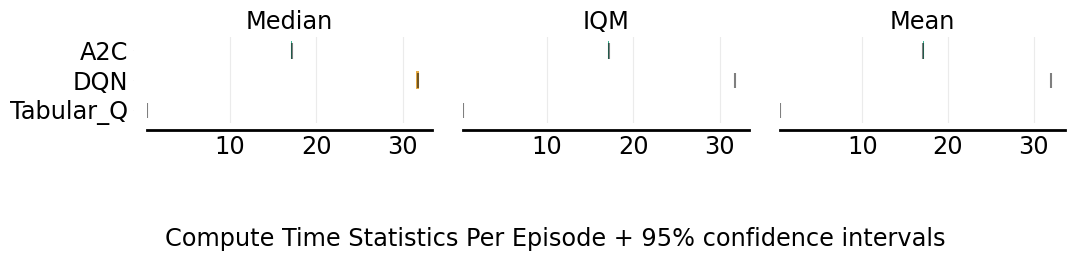

In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd


algorithms = list(training_times.keys())

aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  training_times, aggregate_func, reps=10)


fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean'],
  algorithms=list(training_times.keys()),
  xlabel='Compute Time Statistics In Seconds Per Episode + 95% confidence intervals',
  xlabel_y_coordinate=-1
  )

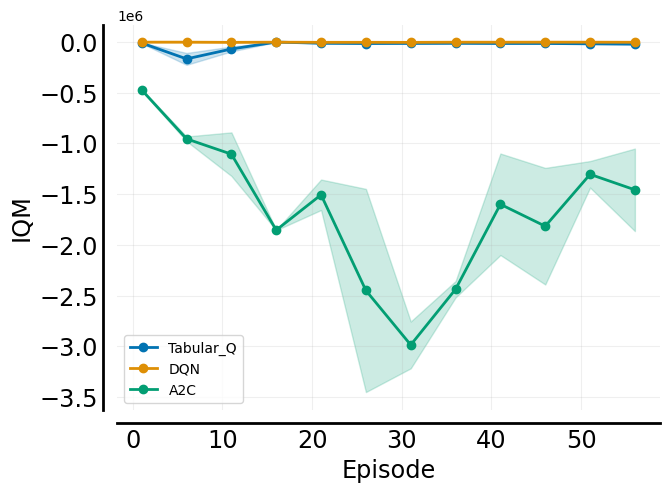

In [ ]:
## IQM learning curves (the IQM for per episode number across different seeds)
frames = np.arange(0, 60, 5)
frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in learning_curves.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  frames_scores_dict, iqm, reps=50)


ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Episode',
    ylabel='IQM')

ax.legend(loc='best')


In [7]:
import pandas as pd
print(learning_curves["DQN"].shape)
learning_curves["A2C"].shape

AttributeError: 'list' object has no attribute 'shape'

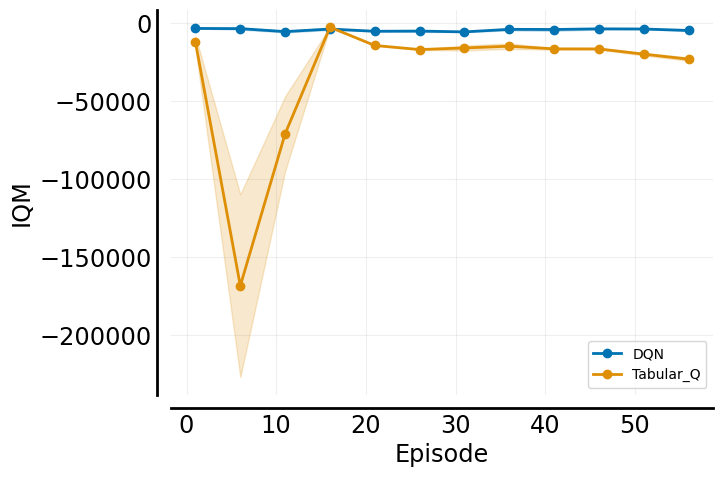

In [ ]:
ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=["DQN", "Tabular_Q"],
    xlabel=r'Episode',
    ylabel='IQM')

ax.legend(loc='best')


In [ ]:
import gymnasium as gym
import numpy as np
import math
import random
from env import WaterSupplyEnv
from gymnasium.spaces import MultiDiscrete
import itertools



class DiscretizedActionWrapper(gym.ActionWrapper):
    """
    Converts a continuous 3-dimensional action space (Box) into a discrete one by mapping 
    each continuous dimension into equally spaced bins. The new discrete action space 
    is a MultiDiscrete space where each element corresponds to one dimension.
    """
    def __init__(self, env, n_bins=5):
        super().__init__(env)
        self.n_bins = n_bins
        
        # Check that the original action space is a 3-dimensional Box.
        assert isinstance(self.action_space, gym.spaces.Box), "This wrapper only supports Box action spaces."
        assert self.action_space.shape == (3,), "This wrapper only supports 3-dimensional Box action spaces."
        
        # Get low and high values for each dimension
        self.low = env.action_space.low  # shape (3,)
        self.high = env.action_space.high  # shape (3,)
        
        # Define a new discrete action space using MultiDiscrete:
        # Each of the three dimensions is discretized into n_bins discrete actions.
        self.action_space = MultiDiscrete([n_bins, n_bins, n_bins])
        
        # Precompute the mapping for each dimension:
        # Each element is a linspace mapping from the low to high for that dimension.
        self.discrete_actions = [np.linspace(low, high, n_bins) for low, high in zip(self.low, self.high)]
    
    def action(self, action):
        """
        Maps the discrete action (a vector of indices for each dimension) 
        to a continuous action.
        
        Args:
            action (array-like): A 3-dimensional vector with discrete indices.
        
        Returns:
            np.array: A continuous action of shape (3,) corresponding to the bin centers.
        """
        # Ensure action is a NumPy array
        action = np.array(action)
        continuous_action = np.array([self.discrete_actions[d][action[d]] for d in range(3)])
        return continuous_action


def copy_water_env(env):
    new_env = WaterSupplyEnv()
    new_env = DiscretizedActionWrapper(new_env)
    inner_env = env.env
    new_env.env.current_hour = inner_env.current_hour
    new_env.env.water_level = inner_env.water_level
    new_env.env.demand = inner_env.demand
    new_env.env.price_A = inner_env.price_A
    new_env.env.price_B = inner_env.price_B
    return new_env

# ------------------------------
# Environment Simulator Using the Real Environment
# ------------------------------
def env_simulator(env:WaterSupplyEnv, state, action_bin):
    """
    Uses the actual environment to simulate one high-level step.
    This requires that the environment supports state cloning and restoration.
    
    Args:
        env: Gym environment instance.
        state: The saved state (obtained via env.clone_state()).
        action_bin: The discrete high-level action (bin index).
    
    Returns:
        next_state: The new state after the action.
        reward: The reward obtained.
        done: Whether the episode terminated.
    """
    # Restore environment to the given state
    env.env.set_state(state)
    
    # Execute the high-level action (for example, using the bin index directly)
    next_state, reward, done, _ = env.step(action_bin)
    return next_state, reward, done

# ------------------------------
# MCTS Implementation (as before)
# ------------------------------
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action  # The discrete action that led to this node
        self.children = {}    # Mapping: action -> child node
        self.visits = 0
        self.total_reward = 0.0

    def uct_score(self, c_param=1.41):
        if self.visits == 0:
            return float('inf')
        q_value = self.total_reward / self.visits
        bonus = c_param * math.sqrt(math.log(self.parent.visits) / self.visits)
        return q_value + bonus

    def expand(self, available_actions, env, horizon, c_param=1.41):
        for action in available_actions:
            if action not in self.children:
                next_state, reward, done = env_simulator(env, self.state, action)
                child_node = MCTSNode(next_state, parent=self, action=action)
                child_node.total_reward = reward
                child_node.visits = 1
                self.children[action] = child_node
                return child_node
        return None

def mcts_search(root_state, env:WaterSupplyEnv, available_actions, n_iters=100, horizon=5, c_param=1.41):
    root = MCTSNode(root_state)
    simulation_env = copy_water_env(env)
    for i in range(n_iters):
        node = root
        depth = 0

        # Selection
        while node.children and depth < horizon:
            best_action = max(node.children, key=lambda a: node.children[a].uct_score(c_param))
            node = node.children[best_action]
            depth += 1
            if node.parent is None:
                break

        # Expansion
        if depth < horizon:
            child = node.expand(available_actions, env, horizon, c_param)
            if child is not None:
                node = child
                depth += 1

        # Simulation (Rollout)
        sim_reward = 0.0
        sim_state = node.state
        discount = 1.0
        for d in range(depth, horizon):
            action = random.choice(available_actions)
            sim_state, reward, done = env_simulator(simulation_env, sim_state, action)
            sim_reward += discount * reward
            discount *= 0.95  # high-level discount factor
            if done:
                break

        # Backpropagation
        total_reward = sim_reward
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    # Choose best high-level action from root
    best_action = None
    best_avg = -float('inf')
    for action, child in root.children.items():
        avg_reward = child.total_reward / child.visits
        if avg_reward > best_avg:
            best_avg = avg_reward
            best_action = action
    return best_action

# ------------------------------
# Usage Example with Real Environment as Simulator
# ------------------------------
# Create the environment
env = WaterSupplyEnv()
env = DiscretizedActionWrapper(env, 5)

# Reset environment and clone initial state
initial_state = env.reset()

available_actions = [item for item in itertools.product(range(5), range(5), range(5))]# Assuming 10 discrete high-level actions

# Run MCTS search using the real environment as simulator
best_action = mcts_search(initial_state, env, available_actions, n_iters=100, horizon=5, c_param=1.41)

# Map the discrete bin to a representative continuous action
def continuous_from_bin(bin_index, num_bins=10, min_val=0.0, max_val=300.0):
    bin_width = (max_val - min_val) / num_bins
    return min_val + bin_width * (bin_index + 0.5)

rep_continuous_action = continuous_from_bin(np.array([best_action]), num_bins=10, min_val=0.0, max_val=300.0)

print("Best high-level action (bin index):", best_action)
print("Representative continuous action for that bin:", rep_continuous_action)


(2, 1, 64)